Natural Language Processing with Disaster Tweets

objective-  Predict which Tweets are about real disasters and which ones are not

 Description


Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).


But, it’s not always clear whether a person’s words are actually announcing a disaster.


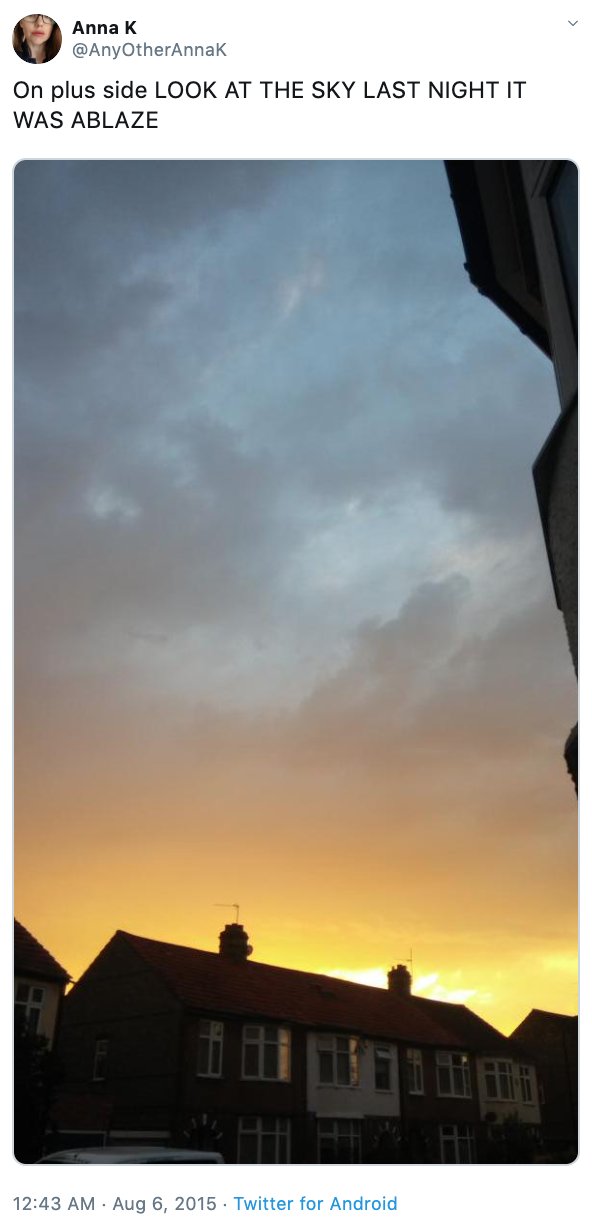

Import libraries

In [1]:
pip install transformers

In [2]:
from wordcloud import WordCloud

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_metadata as metadata
#from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from nltk import compat
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, TFBertModel


loading dataset

In [3]:
sample_submission_data = pd.read_csv('/content/sample_submission[1].csv')
train_data = pd.read_csv('/content/train[1].csv')
test_data = pd.read_csv('/content/test[1].csv')

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_data.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [6]:
train_data.drop_duplicates()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
train_data.fillna

<bound method DataFrame.fillna of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w.

In [8]:
train_data.isnull

<bound method DataFrame.isnull of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w.

In [9]:
train_data.dropna

<bound method DataFrame.dropna of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w.

In [10]:
train_data.value_counts

<bound method DataFrame.value_counts of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of cont

In [11]:
train_data.info

<bound method DataFrame.info of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...

In [12]:
sample_submission_data.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [13]:
sample_submission_data.describe

<bound method NDFrame.describe of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [14]:
sample_submission_data.fillna

<bound method DataFrame.fillna of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [15]:
sample_submission_data.drop_duplicates

<bound method DataFrame.drop_duplicates of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [16]:
sample_submission_data.info

<bound method DataFrame.info of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [17]:
sample_submission_data.isnull

<bound method DataFrame.isnull of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [18]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [19]:
test_data.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [20]:
test_data.info

<bound method DataFrame.info of          id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    Just happened a terrible car crash  
1     Heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              Apocalypse lighting. #Spokane #wildfires  
4         Typhoon Soudelor kills 28 in China and Taiwan  
...                                                 ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  
3259  Storm in RI worse than last hurricane. My city...  
3260  Green Line derailment in Chicago http://t.co/U...  
326

In [21]:
test_data.describe

<bound method NDFrame.describe of          id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    Just happened a terrible car crash  
1     Heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              Apocalypse lighting. #Spokane #wildfires  
4         Typhoon Soudelor kills 28 in China and Taiwan  
...                                                 ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  
3259  Storm in RI worse than last hurricane. My city...  
3260  Green Line derailment in Chicago http://t.co/U...  
3

In [22]:
train_data = pd.read_csv('/content/train[1].csv', usecols=['id','text','target'])

test_data = pd.read_csv('/content/test[1].csv', usecols=['id','text'])
sample_data = pd.read_csv('/content/sample_submission[1].csv')

train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [23]:
sample_submission = train_data.iloc[[7021]].text.to_string(header=False, index=False)
sample_submission

'Obama Declares Disaster for Typhoon-Devastated ...'

In [24]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

There are 7613 rows and 3 columns in train
There are 3263 rows and 2 columns in train


In [25]:
print('There are {} rows and {} columns in test'.format(test_data.shape[0],test_data.shape[1]))
print('There are {} rows and {} colums in test'.format(test_data.shape[0], test_data.shape[1]))

There are 3263 rows and 2 columns in test
There are 3263 rows and 2 colums in test


In [26]:
print('There are {} rows and {} columns in test'.format(sample_submission_data.shape[0],sample_submission_data.shape[1]))
print('There are {} rows and {} columns in test'.format(sample_submission_data.shape[0],sample_submission_data.shape[1]))


There are 3263 rows and 2 columns in test
There are 3263 rows and 2 columns in test


In [27]:
sample_submission_data.describe

<bound method NDFrame.describe of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [28]:
sample_submission_data.fillna

<bound method DataFrame.fillna of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [29]:
sample_submission_data.dtypes

id        int64
target    int64
dtype: object

In [30]:
train_data.dtypes

id         int64
text      object
target     int64
dtype: object

In [31]:
test_data.dtypes


id       int64
text    object
dtype: object

In [32]:
train_data['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [33]:
train_data['id'][1]

4

In [34]:
test_data['text'][1]

'Heard about #earthquake is different cities, stay safe everyone.'

In [35]:
test_data['id'][2]

3

In [36]:
test_data['text'][4]

'Typhoon Soudelor kills 28 in China and Taiwan'

In [37]:
sample_submission_data['target'][1]

0

In [38]:
sample_submission_data['target'].value_counts()

0    3263
Name: target, dtype: int64

undersampling dataset

In [39]:
if True:
 df_0_class = test_data[test_data['text']==0]
 df_1_class = test_data[test_data['text']==1]
 df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
 df = pd.concat([df_0_class_undersampled, df_1_class], axis=0)
 df['text'].value_counts()


In [40]:
if False :
  df_0_class = sample_submission_data[sample_submission_data['target']==0]
  df_1_class = sample_submission_data[sample_submission_data['target']==1]
  df_0_class_undersampled = df_0_class.sample(df_0_class_undersampled.shape[0])
  df = pd.pandas([df_0_class,df_1_class],axis=0)
  df['id'].value_counts()

process Tweets

In [41]:
pip install contractions emoji unidecode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.2 MB/s eta 0:00:00


In [42]:
!pip install contractions emoji unidecode

import contractions
import emoji
import re
import unidecode
from nltk.stem import PorterStemmer

class TweetSweeper:
    def __init__(self, tweets):
        self.tweets = tweets
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        # Expand contractions and remove emojis
        cleaned_text = contractions.fix(text)
        cleaned_text = self.demojize(cleaned_text)
        return cleaned_text

    def preprocess_tweets(self):
        # Tweet Text
        self.tweets['text_clean'] = self.tweets['text'].apply(self.clean_text)
        self.tweets['hashtags'] = self.tweets['text'].apply(lambda x: [word for word in x.split() if word.startswith("#")])

        # Keyword
        self.tweets['keyword'] = self.tweets['keyword'].apply(str)
        self.tweets['keyword'] = self.tweets['keyword'].apply(self.clean_keywords)
        self.tweets['stems'] = self.tweets['keyword'].apply(self.stemmer.stem)

        # Location
        self.tweets['location'] = self.tweets['location'].apply(str)
        self.tweets['location'] = self.tweets['location'].apply(self.clean_location)

        # Counts
        self.tweets['emojis'] = self.tweets['text'].apply(self.emoji_count)
        self.tweets['num_hashtags'] = self.tweets['text'].apply(self.hash_count)
        self.tweets['token_count'] = self.tweets['text'].apply(len)

    def demojize(self, tweet):
        # Remove emojis from the tweet
        emojis_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        cleaned_text = emojis_pattern.sub(r'', tweet)
        return cleaned_text

    def emoji_count(self, tweet):
        # Count the number of emojis in the tweet
        tweet = emoji.demojize(tweet, delimiters=('__','__'))
        pattern = r'_+[a-z_&]+_+'
        return len(re.findall(pattern, tweet))

    def hash_count(self, string):
        # Count the number of hashtags in the tweet
        words = string.split()
        hashtags = [word for word in words if word.startswith('#')]
        return len(hashtags)

    def clean_keywords(self, keyword):
        # Clean keywords (replace '%20' with a space)
        cleaned = re.sub(r'%20', ' ', keyword)
        return cleaned

    def clean_location(self, location):
        # Clean location (remove accents, punctuation, extra whitespaces, and numbers)
        cleaned_location = self.remove_accents(location)
        cleaned_location = self.remove_punctuation(cleaned_location)
        cleaned_location = self.remove_extra_w_space(cleaned_location)
        cleaned_location = self.remove_nums(cleaned_location)
        return cleaned_location

    def remove_accents(self, text):
        # Remove accents from text
        cleaned = unidecode.unidecode(text)
        return cleaned

    def remove_punctuation(self, text):
        # Remove punctuation from text
        cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\\]^_`{|}~\n -']", " ", text)
        return cleaned

    def remove_nums(self, text):
        # Remove numbers from text
        cleaned = re.sub(r'\d+', '', text)
        return cleaned

    def remove_extra_w_space(self, text):
        # Remove extra whitespaces from text
        cleaned_text = re.sub(r"\s+", " ", text).strip()
        return cleaned_text

# Example usage:
# tweet_sweeper = TweetSweeper(your_tweets_dataframe)
# tweet_sweeper.preprocess_tweets()


process the tweets here

In [43]:
sweep_data = TweetSweeper(train_data).tweets.copy()

In [44]:
sweep_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [45]:
sweep_data.tail()

,id,text,target
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1
7612,10873,The Latest: More Homes Razed by Northern Calif...,1


In [46]:
sweep_data.describe

<bound method NDFrame.describe of          id                                               text  target
0         1  Our Deeds are the Reason of this #earthquake M...       1
1         4             Forest fire near La Ronge Sask. Canada       1
2         5  All residents asked to 'shelter in place' are ...       1
3         6  13,000 people receive #wildfires evacuation or...       1
4         7  Just got sent this photo from Ruby #Alaska as ...       1
...     ...                                                ...     ...
7608  10869  Two giant cranes holding a bridge collapse int...       1
7609  10870  @aria_ahrary @TheTawniest The out of control w...       1
7610  10871  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611  10872  Police investigating after an e-bike collided ...       1
7612  10873  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 3 columns]>

In [47]:


# Assuming 'sweep_data' is your DataFrame
sweep_data[['text', 'target']][sweep_data['text'] != sweep_data['target']].head(100)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
95,9 Mile backup on I-77 South...accident blockin...,1
96,Has an accident changed your life? We will hel...,0
97,#BREAKING: there was a deadly motorcycle car a...,1
98,@flowri were you marinading it or was it an ac...,0


remove Stops words

In [48]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

# Assuming train_data and test_data are your DataFrames

sample_submission_data['target'] = sample_submission_data['target'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


sample_submission_data.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [49]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

# Assuming train_data and test_data are your DataFrames
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


train_data.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text,target
0,1,Our Deeds Reason #earthquake May ALLAH Forgive us,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked 'shelter place' notified o...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent photo Ruby #Alaska smoke #wildfi...,1


In [50]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

# Assuming train_data and test_data are your DataFrames

test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


test_data.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text
0,0,Just happened terrible car crash
1,2,"Heard #earthquake different cities, stay safe ..."
2,3,"forest fire spot pond, geese fleeing across st..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 China Taiwan


Lemmatization

In [51]:
def word_lemmatizer(target):
  lemmatizer = WordNetLemmatizer()
  lemmatizer = WordCloud()
  return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [52]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Assuming train_data and test_data are your DataFrames
lemmatizer = WordNetLemmatizer()

train_data['text'] = train_data['text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))
test_data['text'] = test_data['text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [53]:
train_data.head()

,id,text,target
0,1,Our Deeds Reason #earthquake May ALLAH Forgive u,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All resident asked 'shelter place' notified of...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent photo Ruby #Alaska smoke #wildfi...,1


In [54]:
test_data.drop_duplicates

<bound method DataFrame.drop_duplicates of          id                                               text
0         0                   Just happened terrible car crash
1         2  Heard #earthquake different cities, stay safe ...
2         3  forest fire spot pond, goose fleeing across st...
3         9           Apocalypse lighting. #Spokane #wildfires
4        11              Typhoon Soudelor kill 28 China Taiwan
...     ...                                                ...
3258  10861  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259  10865  Storm RI worse last hurricane. My city&amp;3ot...
3260  10868  Green Line derailment Chicago http://t.co/UtbX...
3261  10874  MEG issue Hazardous Weather Outlook (HWO) http...
3262  10875  #CityofCalgary activated Municipal Emergency P...

[3263 rows x 2 columns]>

In [55]:
test_data.head()

,id,text
0,0,Just happened terrible car crash
1,2,"Heard #earthquake different cities, stay safe ..."
2,3,"forest fire spot pond, goose fleeing across st..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kill 28 China Taiwan


Feature Engineering

In [56]:
def df_to_dataset(dataframe, shuffle=True,batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Explorarity Data Analysis (EDA)


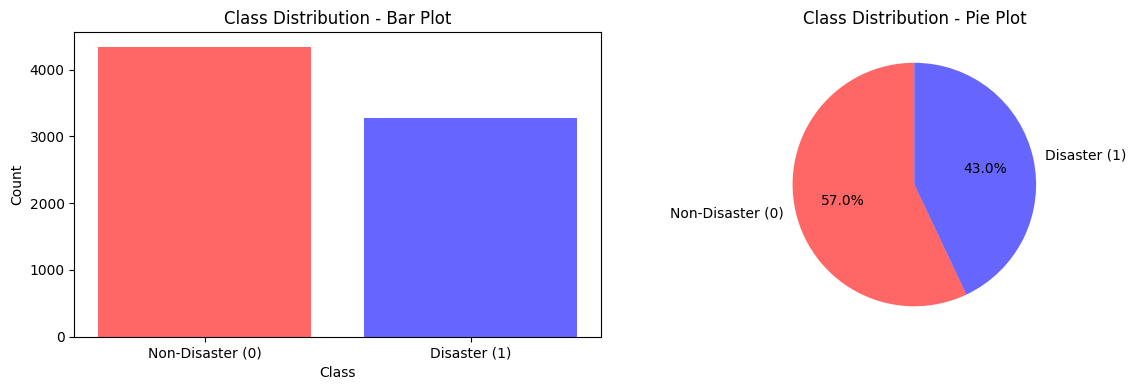

In [57]:
import matplotlib.pyplot as plt

# Assuming train_data is your DataFrame

# Count the occurrences of each target class
target_counts = train_data['target'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
axes[0].bar(target_counts.index, target_counts.values, color=['red', 'blue'], alpha=0.6)
axes[0].set_xticks(target_counts.index)
axes[0].set_xticklabels(['Non-Disaster (0)', 'Disaster (1)'])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution - Bar Plot')

# Pie plot
colors_with_alpha = [(1, 0, 0, 0.6), (0, 0, 1, 0.6)]
axes[1].pie(target_counts, labels=['Non-Disaster (0)', 'Disaster (1)'], colors=colors_with_alpha, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution - Pie Plot')

plt.tight_layout()
plt.show()


word cloud in train and test data

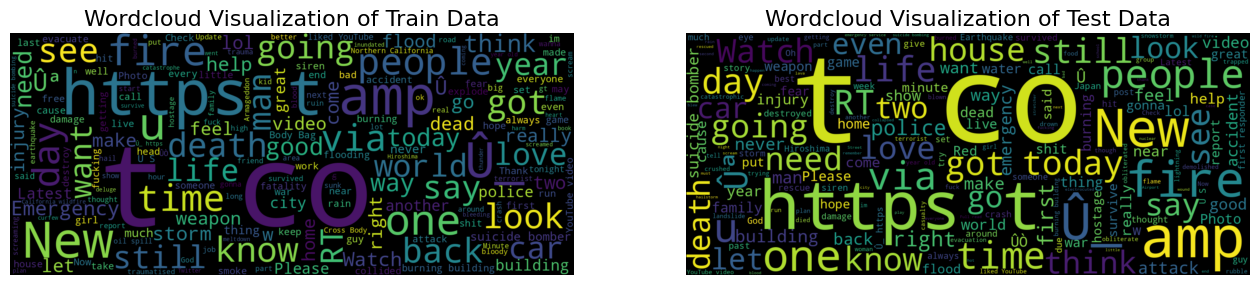

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_and_display_wordcloud(data, title, ax):
    wordcloud = WordCloud(width=1400, height=600, background_color='black').generate(' '.join(data['text']))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Wordcloud Visualization of {title}', fontsize=16)
    ax.axis('off')

num_subplots = 2
fig, axs = plt.subplots(1, num_subplots, figsize=(16, 8) if num_subplots > 1 else (8, 4))

generate_and_display_wordcloud(train_data, 'Train Data', axs[0])
generate_and_display_wordcloud(test_data, 'Test Data', axs[1] if num_subplots > 1 else axs[0])

plt.show()


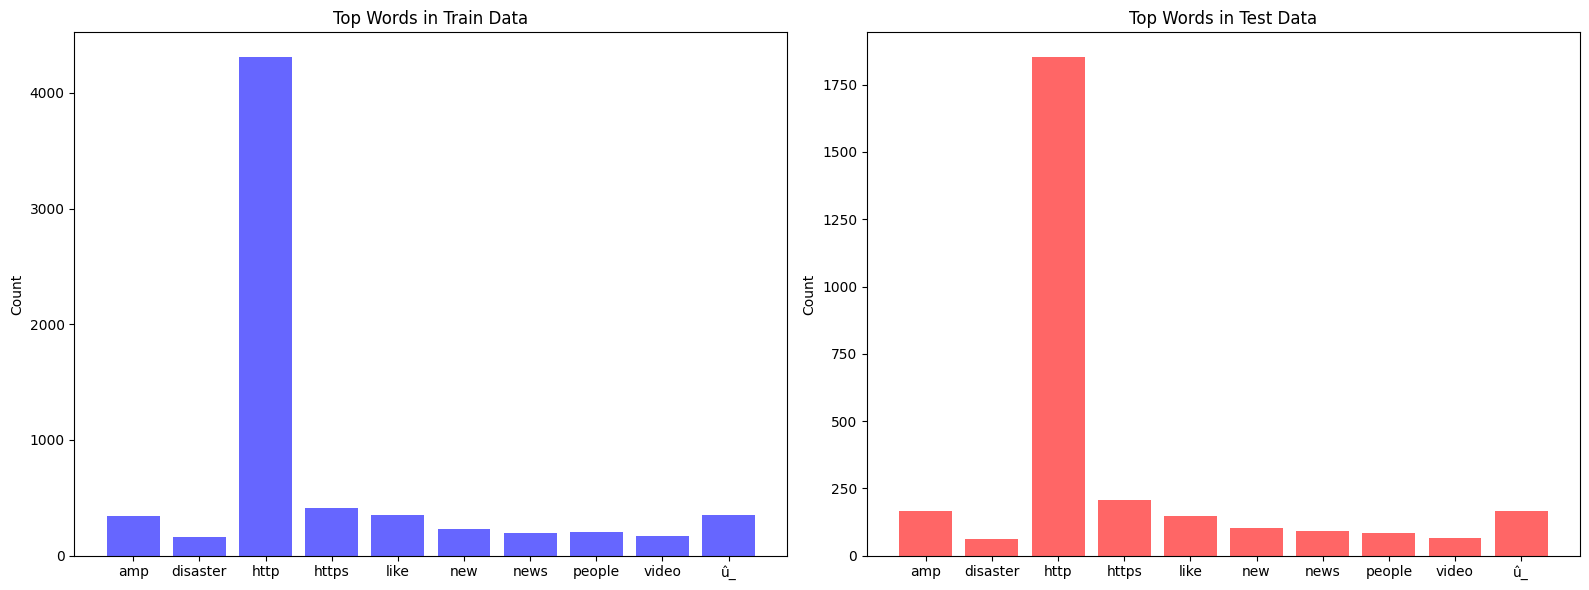

In [59]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Assuming train_data and test_data are your DataFrames
train_text = ' '.join(train_data['text'])
test_text = ' '.join(test_data['text'])

# Create CountVectorizer to get top words
vectorizer = CountVectorizer(stop_words='english', max_features=10)
train_word_counts = vectorizer.fit_transform([train_text])
test_word_counts = vectorizer.transform([test_text])

# Get top words and their counts
train_word_counts = pd.Series(train_word_counts.toarray().flatten(), index=vectorizer.get_feature_names_out())
test_word_counts = pd.Series(test_word_counts.toarray().flatten(), index=vectorizer.get_feature_names_out())

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train Data
axs[0].bar(train_word_counts.index, train_word_counts.values, color='blue', alpha=0.6)
axs[0].set_title('Top Words in Train Data')
axs[0].set_ylabel('Count')

# Test Data
axs[1].bar(test_word_counts.index, test_word_counts.values, color='red', alpha=0.6)
axs[1].set_title('Top Words in Test Data')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


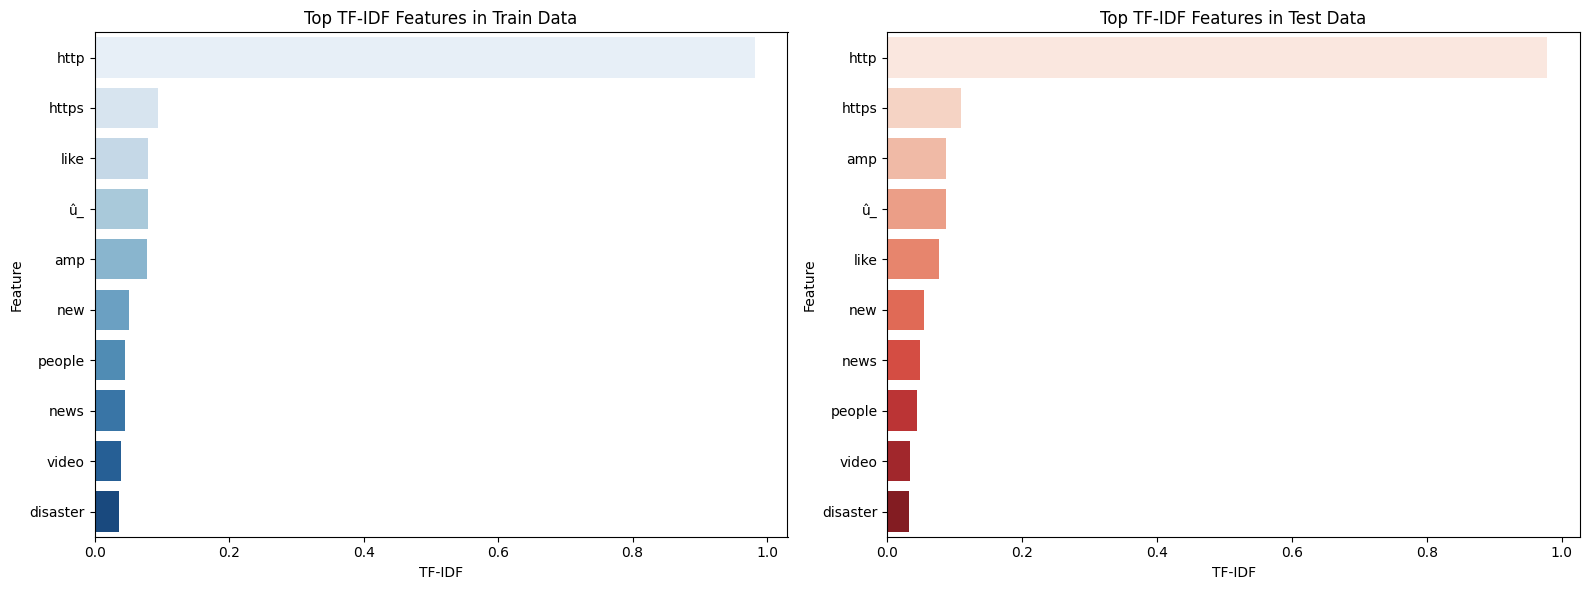

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

# Assuming train_data and test_data are your DataFrames
train_text = ' '.join(train_data['text'])
test_text = ' '.join(test_data['text'])

# Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
train_tfidf = vectorizer.fit_transform([train_text])
test_tfidf = vectorizer.transform([test_text])

# Get feature names and TF-IDF values
feature_names = vectorizer.get_feature_names_out()
train_tfidf_values = train_tfidf.toarray().flatten()
test_tfidf_values = test_tfidf.toarray().flatten()

# Create a DataFrame for visualization
df_train_tfidf = pd.DataFrame({'Feature': feature_names, 'TF-IDF': train_tfidf_values})
df_test_tfidf = pd.DataFrame({'Feature': feature_names, 'TF-IDF': test_tfidf_values})

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train Data
sns.barplot(x='TF-IDF', y='Feature', data=df_train_tfidf.sort_values(by='TF-IDF', ascending=False), ax=axs[0], palette='Blues')
axs[0].set_title('Top TF-IDF Features in Train Data')

# Test Data
sns.barplot(x='TF-IDF', y='Feature', data=df_test_tfidf.sort_values(by='TF-IDF', ascending=False), ax=axs[1], palette='Reds')
axs[1].set_title('Top TF-IDF Features in Test Data')

plt.tight_layout()
plt.show()


In [61]:
import seaborn as sns

# Assuming train_data is your DataFrame
target_0_text = train_data[train_data['target'] == 0]['text']
target_1_text = train_data[train_data['target'] == 1]['text']

# Combine the data into a single DataFrame for Seaborn
df = pd.concat([target_0_text.str.split().apply(len).rename('UniqueWords'),
                target_1_text.str.split().apply(len).rename('UniqueWords')],
               keys=['0 (Non-Disaster)', '1 (Disaster)'], axis=1)

# Rest of the code remains the same...
print("Target 0 Text:")
print(target_0_text.head())
print("\nTarget 1 Text:")
print(target_1_text.head())


Target 0 Text:
15                   What's man?
16                  I love fruit
17                 Summer lovely
18                   My car fast
19    What goooooooaaaaaal!!!!!!
Name: text, dtype: object

Target 1 Text:
0     Our Deeds Reason #earthquake May ALLAH Forgive u
1               Forest fire near La Ronge Sask. Canada
2    All resident asked 'shelter place' notified of...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent photo Ruby #Alaska smoke #wildfi...
Name: text, dtype: object


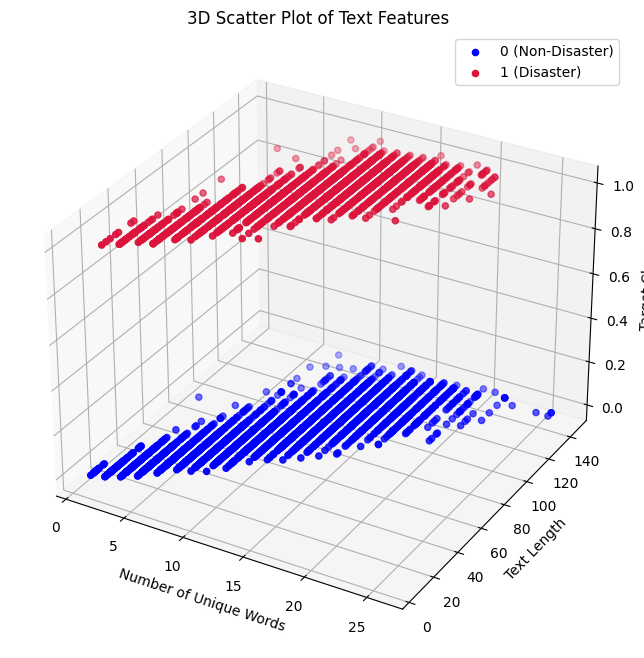

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming train_data is your DataFrame
target_0_text = train_data[train_data['target'] == 0]['text']
target_1_text = train_data[train_data['target'] == 1]['text']

# Extract features for 3D plot
target_0_unique_words = target_0_text.str.split().apply(set).apply(len)
target_1_unique_words = target_1_text.str.split().apply(set).apply(len)

target_0_text_length = target_0_text.apply(len)
target_1_text_length = target_1_text.apply(len)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(target_0_unique_words, target_0_text_length, [0] * len(target_0_text), c='blue', label='0 (Non-Disaster)')
ax.scatter(target_1_unique_words, target_1_text_length, [1] * len(target_1_text), c='crimson', label='1 (Disaster)')

ax.set_xlabel('Number of Unique Words')
ax.set_ylabel('Text Length')
ax.set_zlabel('Target Class')
ax.set_title('3D Scatter Plot of Text Features')

plt.legend()
plt.show()


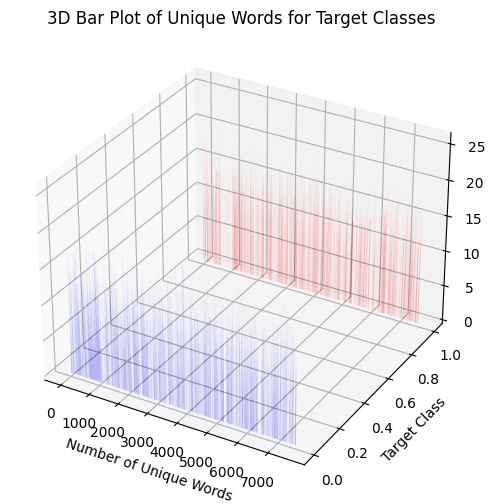

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming train_data is your DataFrame
target_0_text = train_data[train_data['target'] == 0]['text']
target_1_text = train_data[train_data['target'] == 1]['text']

# Calculate the number of unique words for each target class
unique_words_0 = target_0_text.str.split().apply(set).apply(len)
unique_words_1 = target_1_text.str.split().apply(set).apply(len)

# Create a 3D bar plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting bars for target class 0
ax.bar(unique_words_0.index, unique_words_0.values, zs=0, zdir='y', width=0.5, color='b', alpha=0.6)

# Plotting bars for target class 1
ax.bar(unique_words_1.index, unique_words_1.values, zs=1, zdir='y', width=0.5, color='r', alpha=0.6)

# Set labels and title
ax.set_xlabel('Number of Unique Words')
ax.set_ylabel('Target Class')
ax.set_zlabel('Density')
ax.set_title('3D Bar Plot of Unique Words for Target Classes')

plt.show()


In [64]:
import nltk
from nltk.corpus import movie_reviews
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('movie_reviews')

# Load movie reviews dataset
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Shuffle the documents
import random
random.shuffle(documents)

# Tokenize and lemmatize the words
lemmatizer = WordNetLemmatizer()
all_words = [lemmatizer.lemmatize(word.lower()) for word in movie_reviews.words()]

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform([' '.join(words) for words, _ in documents])
y = [category for _, category in documents]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Accuracy: 0.80

Confusion Matrix:
[[168  25]
 [ 56 151]]

Classification Report:
              precision    recall  f1-score   support

         neg       0.75      0.87      0.81       193
         pos       0.86      0.73      0.79       207

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.81      0.80      0.80       400



create a N-grams

 Basic understanding n-grams

Based on the value of n we can generate different ngrams as follows:

• N = 1 (Unigrams): This, is, a, sentence

• N = 2 (Bigrams): This is, is a, a sentence

• N = 3 (Trigrams): This is a, is a sentence

In [65]:
def get_top_ngrams(text, n=100, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngrams = vectorizer.fit_transform(text)
    sum_ngrams = ngrams.sum(axis=0)
    ngram_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    return ngram_freq[:n]

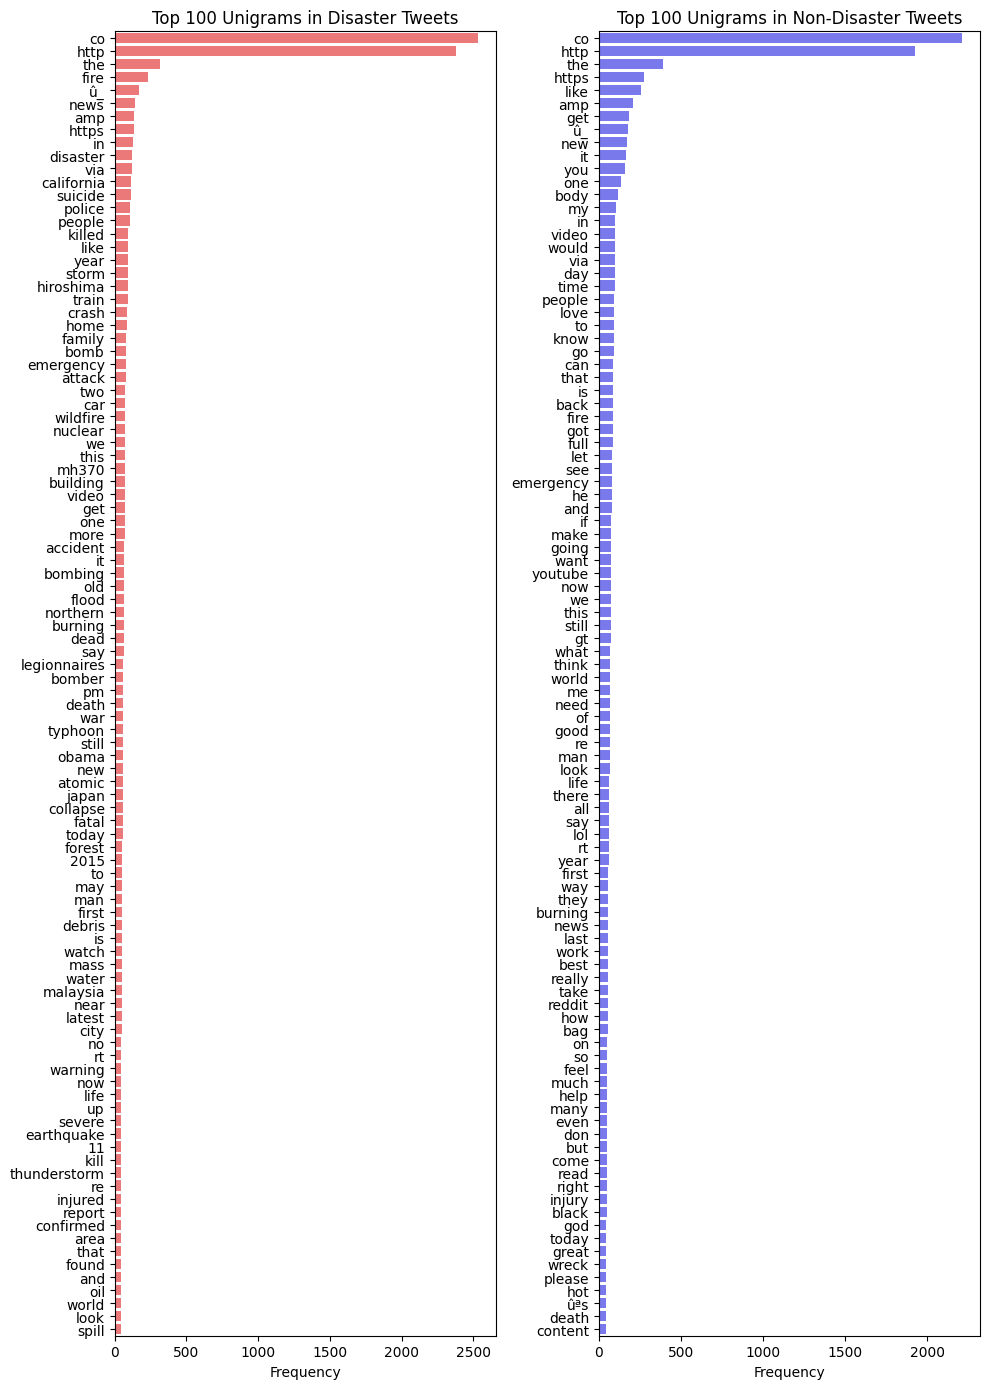

In [66]:
def plot_top_ngrams(ngrams, title, color, ax):
    sns.barplot(y=[word[0] for word in ngrams], x=[word[1] for word in ngrams], ax=ax, color=color, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Frequency')

disaster_unigrams = get_top_ngrams(train_data[train_data['target'] == 1]['text'], n=100, ngram_range=(1, 1))
non_disaster_unigrams = get_top_ngrams(train_data[train_data['target'] == 0]['text'], n=100, ngram_range=(1, 1))

fig, axes = plt.subplots(dpi=100, figsize=(10, 14), ncols=2)

plot_top_ngrams(disaster_unigrams, 'Top 100 Unigrams in Disaster Tweets', 'red', axes[0])
plot_top_ngrams(non_disaster_unigrams, 'Top 100 Unigrams in Non-Disaster Tweets', 'blue', axes[1])

plt.tight_layout()
plt.show()


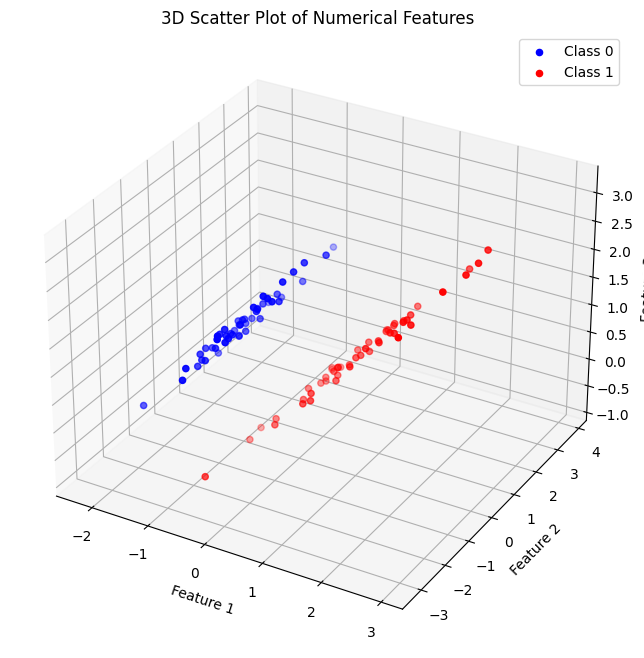

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

# Create a synthetic dataset for illustration
X, y = make_classification(
    n_samples=100,
    n_features=3,  # Number of total features
    n_informative=2,  # Number of informative features
    n_redundant=0,  # Number of redundant features
    n_clusters_per_class=1,  # Number of clusters per class
    random_state=42
)

# Separate data points based on class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for class 0
ax.scatter(class_0[:, 0], class_0[:, 1], class_0[:, 2], c='blue', label='Class 0')

# Scatter plot for class 1
ax.scatter(class_1[:, 0], class_1[:, 1], class_1[:, 2], c='red', label='Class 1')

# Set labels and title
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Numerical Features')

# Show legend
ax.legend()

plt.show()



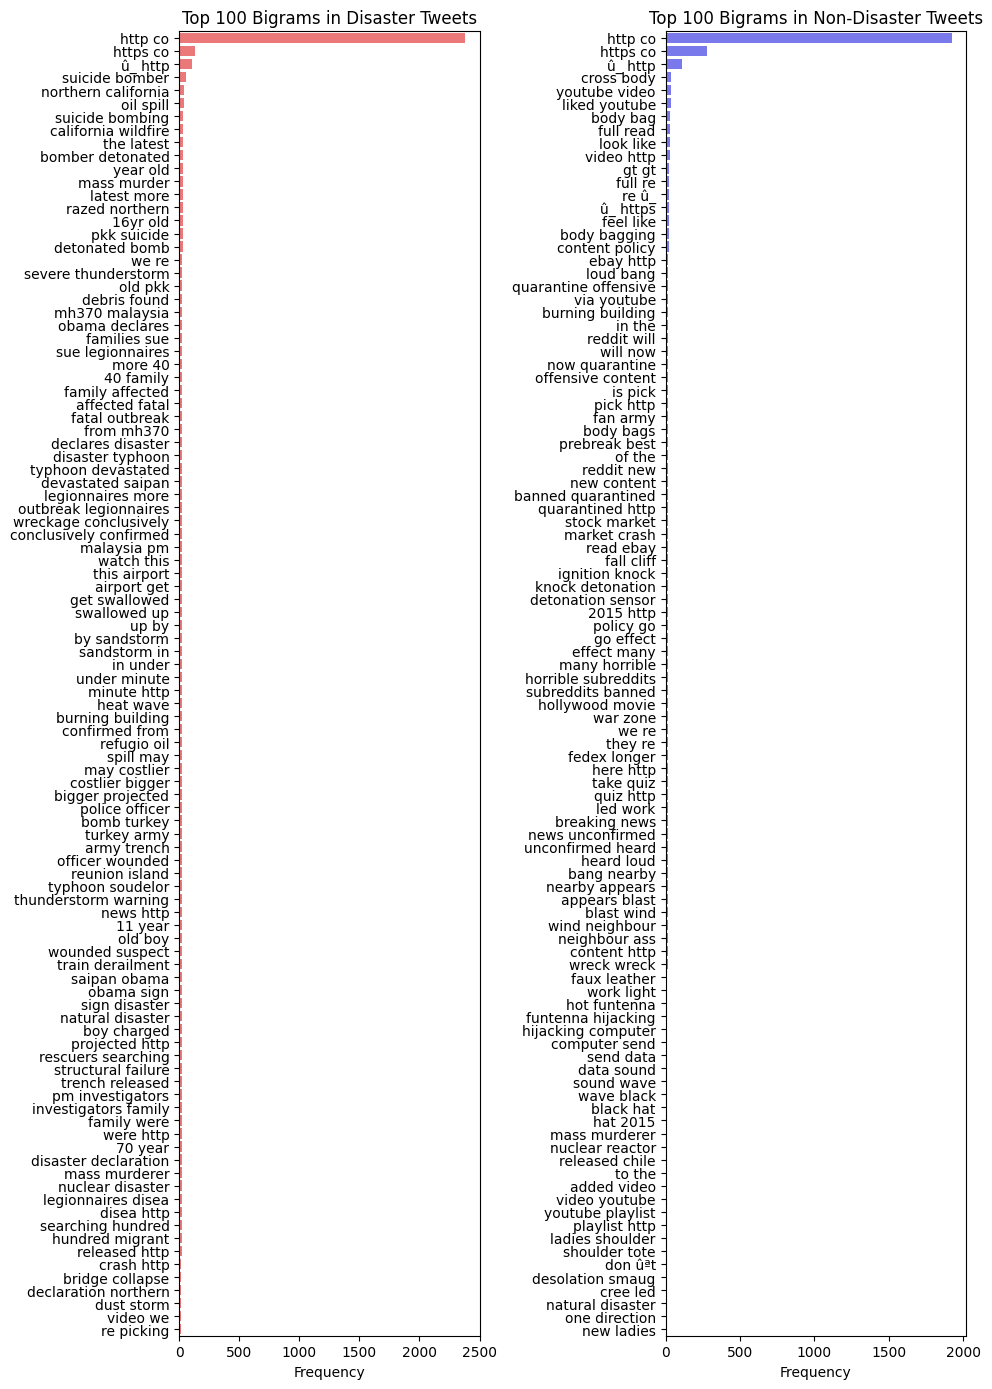

In [68]:
def plot_top_ngrams(ngrams, title, color, ax):
    sns.barplot(y=[word[0] for word in ngrams], x=[word[1] for word in ngrams], ax=ax, color=color, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Frequency')

disaster_bigrams = get_top_ngrams(train_data[train_data['target'] == 1]['text'], n=100, ngram_range=(2, 2))
non_disaster_bigrams = get_top_ngrams(train_data[train_data['target'] == 0]['text'], n=100, ngram_range=(2, 2))

fig, axes = plt.subplots(dpi=100, figsize=(10, 14), ncols=2)

plot_top_ngrams(disaster_bigrams, 'Top 100 Bigrams in Disaster Tweets', 'red', axes[0])
plot_top_ngrams(non_disaster_bigrams, 'Top 100 Bigrams in Non-Disaster Tweets', 'blue', axes[1])

plt.tight_layout()
plt.show()


BERT- Bidirectional Encoder Representation from transformers

In [69]:
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert = TFBertModel.from_pretrained('bert-large-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [70]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [71]:
print("max len of tweets",max([len(x.split()) for x in train_data['text']]))

max len of tweets 28


In [72]:
print("max len of tweets",max([len(x.split()) for x in test_data['text']]))

max len of tweets 28


In [73]:
print("max len of tweets",max([len(x.split()) for x in sample_submission_data['target']]))

max len of tweets 1


In [74]:
X_train.shape


(1600, 39659)

In [75]:
X_test.shape

(400, 39659)

In [76]:
X_train.shape

(1600, 39659)

In [77]:
X_test.shape

(400, 39659)

In [78]:
y_train = train_data['target'].values
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

GPT stands for Generative Pre-trained Transformer

GPT stands for Generative Pre-trained Transformer. It's a type of

machine learning model that's used in ChatGPT to generate human-like

responses to user prompts.




In [79]:
from transformers import AutoTokenizer

# Replace 'gpt2' with the GPT model you want to use, e.g., 'openai-gpt' or 'gpt2-medium'
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example text
text = "This is an example sentence for GPT tokenization."

# Tokenize the text
tokens = tokenizer.encode(text, add_special_tokens=True)

# Decode the tokens back to text
decoded_text = tokenizer.decode(tokens)

# Print the results
print("Original text:", text)
print("Tokenized IDs:", tokens)
print("Decoded text:", decoded_text)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Original text: This is an example sentence for GPT tokenization.
Tokenized IDs: [1212, 318, 281, 1672, 6827, 329, 402, 11571, 11241, 1634, 13]
Decoded text: This is an example sentence for GPT tokenization.


In [80]:
from transformers import AutoTokenizer, TFAutoModel
#Replace 'gpt2' with the GPT model you want to use e.g. 'open-ai'-gpt

model_name = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt_model = TFAutoModel.from_pretrained(model_name)


# tokenization the text
tokens = tokenizer.encode(text, add_special_tokens=True)
print("original text:" , text)
print("Tokenized IDs:", tokens)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


original text: This is an example sentence for GPT tokenization.
Tokenized IDs: [1212, 318, 281, 1672, 6827, 329, 402, 11571, 11241, 1634, 13]


In [81]:
# Tokenize all texts
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in test_data]

# Find the maximum length
max_length = max(len(tokens) for tokens in tokenized_texts)
min_length = min(len(tokens) for tokens in tokenized_texts)

print("Max length of tokens in GPT:", max_length)
print("Min length of tokens in GPT:", min_length)

Max length of tokens in GPT: 1
Min length of tokens in GPT: 1


In [82]:
from transformers import AutoTokenizer

# Replace 'gpt2' with the GPT model you want to use, e.g., 'openai-gpt' or 'gpt2-medium'
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example text
text_data = train_data['text'].tolist()

# Tokenize all texts
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in text_data]

# Find the maximum length
max_length = max(len(tokens) for tokens in tokenized_texts)

print("Max length of tokens in GPT:", max_length)


Max length of tokens in GPT: 81


In [83]:
## 🏗️**Build the Model Architecture**

In [84]:
input_ids = Input(shape=(23,), dtype=tf.int32, name = 'input_ids')
attention_mask = Input(shape=(23,), dtype=tf.int32, name = 'attention_mask')

In [85]:
embeddings = bert(input_ids = input_ids, attention_mask = attention_mask)[0]

In [86]:
layer = layers.Dropout(0.2)(embeddings)
layer = layers.Dense(1024, activation = 'relu')(layer)
layer = layers.Dense(32, activation = 'relu')(layer)
layer = layers.Flatten()(layer)
y = layers.Dense(1, activation = 'sigmoid')(layer)

In [87]:
model = keras.Model(inputs = [input_ids, attention_mask], outputs = y)

In [88]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 23)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 23)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   3351418   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   88         'attention_mask[0][0]']      
                             hidden_state=(None, 23, 10                                       

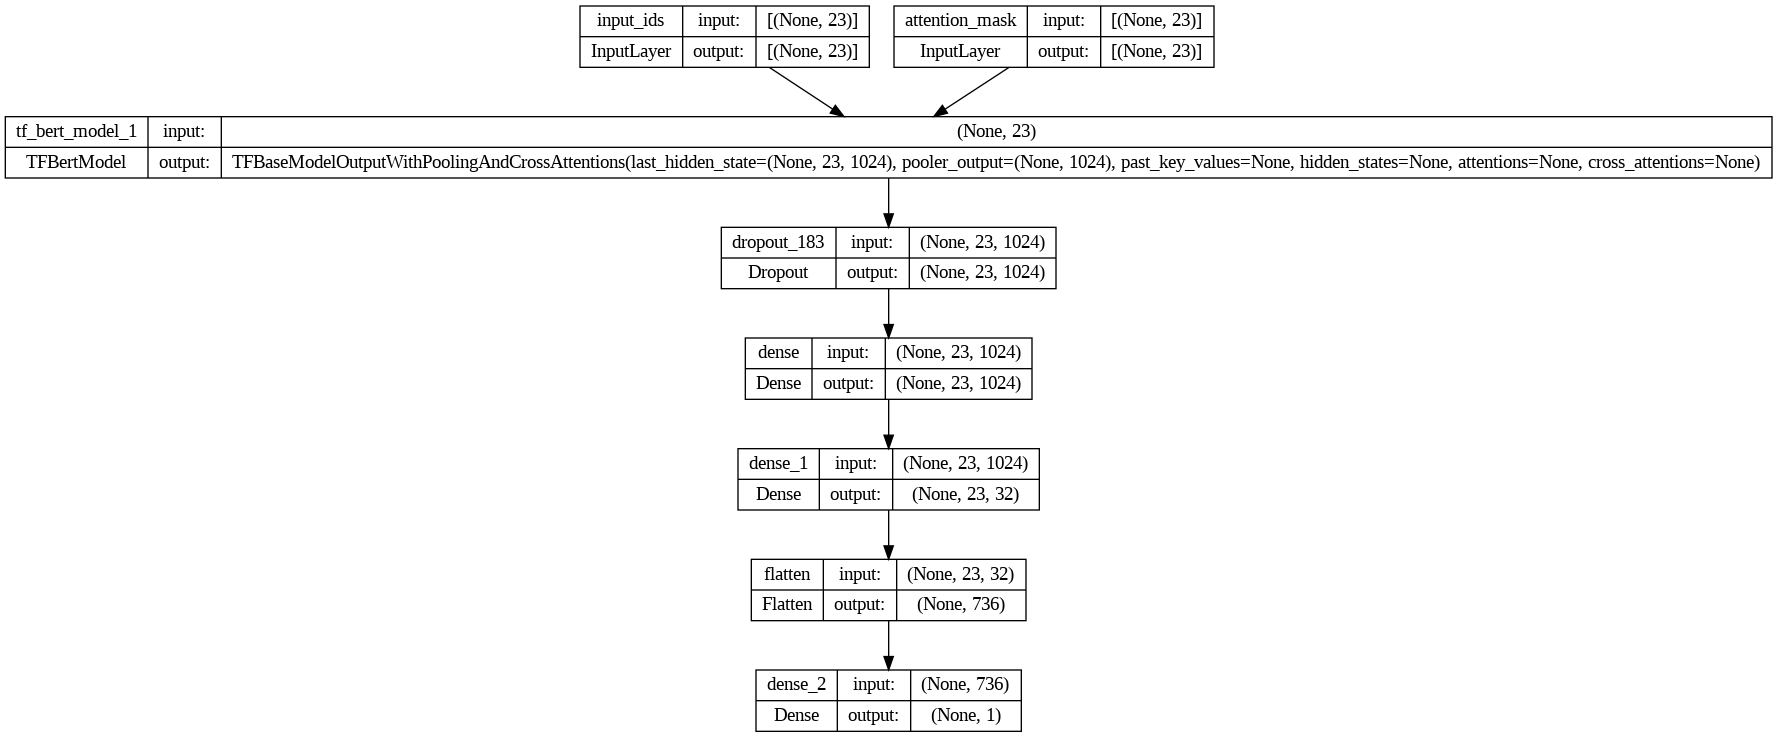

In [89]:
plot_model(model, show_shapes = True)

In [90]:
optimizer = Adam(
    learning_rate=6e-06,
    epsilon=1e-08,
    weight_decay=0.01,
    clipnorm=1.0)

loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')

model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)